In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

In [2]:
#File importation
str0="ts_L60_Z12_A500_DX50_bias5_N10000"
fnamex ="DATA/x_" + str0 + ".csv"
fnamey ="DATA/y_" + str0 + ".csv"

x = np.loadtxt(fnamex,delimiter=',',dtype=float)
N = len(x)
print('Length of x = ',N)



categ = np.loadtxt(fnamey,delimiter=',', dtype=int)
#Number of categories
N_categ = 3
y = np.zeros((N,N_categ))

for n in range(N):
    y[n][categ[n]] = 1
    
print(y[0])



Length of x =  10000
[1. 0. 0.]


In [3]:
#We saw that the nn was not converging and it might be
#due to some average, so we are going to remove it

xm = x.mean(axis=1)
for n in range(N):
    x[n] = x[n]-xm[n]
    
std = x.std(axis=1)
for n in range(N):
    x[n] = x[n] / std[n]  

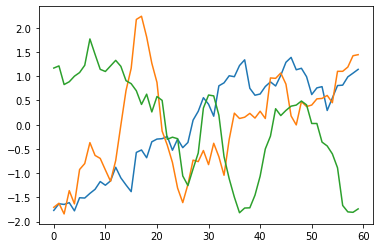

In [4]:
#Data visualization
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

In [5]:
#We asign the data for training and test
perc_train = 0.8
N_train = int(N * perc_train)
N_val = N-N_train

x_train = x[:N_train]
y_train = y[:N_train]

x_val = x[N_train:]
y_val = y[N_train:]

L =len(x[0])

print('Number of samples',N)
print('Training samples',N_train)
print('Validation samples',N_val)
print('Length of x[0]',L)

Number of samples 10000
Training samples 8000
Validation samples 2000
Length of x[0] 60


In [6]:
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

In [7]:
from keras import initializers,regularizers
np.random.seed(12345)

#We use l1 for Lazzo regularization
reg = regularizers.l1(0.1)   

#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)

model = Sequential()
model.add(Conv1D(filters =5, kernel_size =11, 
                 kernel_regularizer = reg,
                 kernel_initializer = ini,
                 activation = 'relu',
                 input_shape =input_shape))

model.add(AveragePooling1D(5))
model.add(Conv1D(filters=5,kernel_size=7,activation="relu"))
model.add(Flatten())
model.add(Dense(10,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(N_categ,activation='softmax'))

print(model.summary())

from keras import optimizers
opt =optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True,decay=1.e6)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=opt,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [8]:
batch_size =250
epochs = 30

fit = model.fit(x_train,y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x_val,y_val),
               verbose=2, shuffle=True)

Epoch 1/30
32/32 - 2s - loss: 1.2818 - accuracy: 0.3316 - val_loss: 1.2704 - val_accuracy: 0.3420
Epoch 2/30
32/32 - 0s - loss: 1.2681 - accuracy: 0.3329 - val_loss: 1.2689 - val_accuracy: 0.3415
Epoch 3/30
32/32 - 0s - loss: 1.2682 - accuracy: 0.3286 - val_loss: 1.2689 - val_accuracy: 0.3415
Epoch 4/30
32/32 - 0s - loss: 1.2676 - accuracy: 0.3294 - val_loss: 1.2689 - val_accuracy: 0.3415
Epoch 5/30
32/32 - 0s - loss: 1.2679 - accuracy: 0.3311 - val_loss: 1.2689 - val_accuracy: 0.3415
Epoch 6/30
32/32 - 0s - loss: 1.2676 - accuracy: 0.3291 - val_loss: 1.2689 - val_accuracy: 0.3415
Epoch 7/30
32/32 - 0s - loss: 1.2677 - accuracy: 0.3288 - val_loss: 1.2689 - val_accuracy: 0.3415
Epoch 8/30
32/32 - 0s - loss: 1.2682 - accuracy: 0.3281 - val_loss: 1.2689 - val_accuracy: 0.3415
Epoch 9/30
32/32 - 0s - loss: 1.2675 - accuracy: 0.3276 - val_loss: 1.2689 - val_accuracy: 0.3415
Epoch 10/30
32/32 - 0s - loss: 1.2673 - accuracy: 0.3280 - val_loss: 1.2689 - val_accuracy: 0.3415
Epoch 11/30
32/32 -

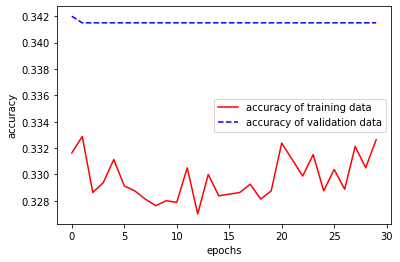

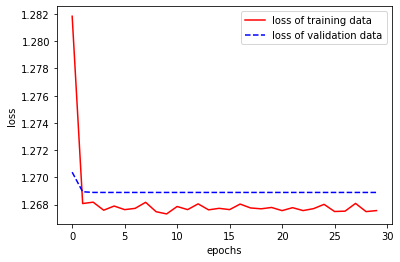

In [9]:
for obs in ('accuracy','loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit.history[obs],'r',
            label =obs+' of training data')
    
    #dashed line!!
    plt.plot(fit.history['val_'+obs],'b--',
            label =obs+' of validation data')
    
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()